In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline
sns.set()

-----

# EDA for babynames

General Tasks: Find good name that starts with 'S', for both boy and girl

## Load Data

In [3]:
raw_national = pd.read_csv("../data/NationalNames.csv")
raw_national.shape

(1825737, 5)

In [4]:
raw_national.head()

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


In [5]:
# more than 5M rows, let's choose a sample
# raw_nat_sample = raw_national.sample(n=100000)

raw_nat_sample = raw_national.copy()
raw_nat_sample.shape

(1825737, 5)

### Pythonize Column Names

In [6]:
# take a look
raw_nat_sample.columns = map(lambda x : x.lower().replace(' ','_').replace('count','frequency'),raw_nat_sample.columns)
raw_nat_sample.head(10)

,id,name,year,gender,frequency
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746
5,6,Margaret,1880,F,1578
6,7,Ida,1880,F,1472
7,8,Alice,1880,F,1414
8,9,Bertha,1880,F,1320
9,10,Sarah,1880,F,1288


In [7]:
# we don't care about 'state', let's drop it
groups = raw_nat_sample.groupby(['name','year','gender'])
raw_nat_sample = groups.aggregate({'id':min,'frequency':sum}).reset_index().set_index('id')
raw_nat_sample.head()

,name,year,gender,frequency
id,,,,
1585933,Aaban,2007,M,5
1654167,Aaban,2009,M,6
1685637,Aaban,2010,M,9
1718295,Aaban,2011,M,11
1752147,Aaban,2012,M,11


### Task 1: find out classical names

Classical name is names with longest historical data. Because if a name appears in each every year, it means it's popular.

In [8]:
name_year_count = raw_nat_sample.copy()
name_year_count['history'] = name_year_count.groupby(['name','gender'])['year'].transform('count')
name_year_count.head(10)

,name,year,gender,frequency,history
id,,,,,
1585933,Aaban,2007,M,5,7
1654167,Aaban,2009,M,6,7
1685637,Aaban,2010,M,9,7
1718295,Aaban,2011,M,11,7
1752147,Aaban,2012,M,11,7
1784445,Aaban,2013,M,14,7
1817171,Aaban,2014,M,16,7
1705078,Aabha,2011,F,7,3
1742455,Aabha,2012,F,5,3


In [9]:
# find names with most long history data
def get_classical_name_billboard(since=1880):
    return name_year_count[name_year_count.year >= since].groupby(['name','gender']) \
    .aggregate({'frequency':sum,'history':min}) \
    .sort_values(by=['history','frequency'], ascending=False)

#t = get_classical_name_billboard()
#print(t.ix[(t.index.get_level_values('Rachel',level='name')) & (t.index.get_level_values('F',level='gender'))])
#print(t.loc['Rachel','F'])

print(get_classical_name_billboard().head())
def find_classical_rank(name,gender,since=1910):
    '''
    name, e.g.'John'
    gender, e.g. 'M' or 'F'
    
    return: rank in classical name billboard
    '''
    #print(names_with_long_history_sorted.head())
    billboard = get_classical_name_billboard(since).reset_index()
    return billboard[(billboard.name==name) & (billboard.gender==gender)].index[0]+1


find_classical_rank('Rachel','F',since=1910)

                frequency  history
name    gender                    
James   M         5106285      135
John    M         5085371      135
Robert  M         4796992      135
Michael M         4309607      135
Mary    F         4115456      135


79

('James', 'M')


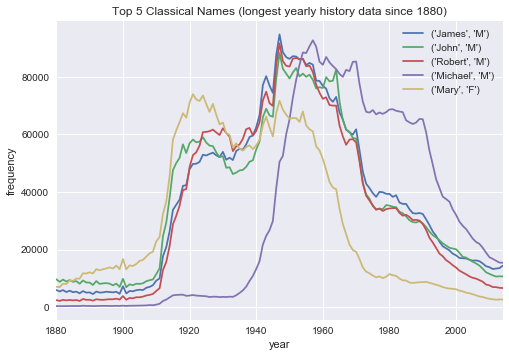

In [10]:
# print the most classical name (name with longest yearly history data)

N = 5
since=1880

classical_billboard = get_classical_name_billboard(since=since)
classical_billboard.head()
print(classical_billboard.index[0])
# print(classical_billboard[classical_billboard.index[0]])
year_frequency = name_year_count.groupby(['name','gender','year']).frequency.sum()
for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_frequency[classical_billboard.index[i]].plot(kind='line');
plt.legend(classical_billboard.index[:N])
plt.title(f"Top {N} Classical Names (longest yearly history data since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Taks 2: find out frequent names

Frequent names is purely depends on frequency of past occurance, since a particular year, regardless of "how many years of historical data".

In [11]:
def get_frequent_name_billboard(since=1880):
    '''
    since: begining of year
    
    return: list of [name, gender, avg_year_frequency]
    '''
    return name_year_count[name_year_count.year >= since].groupby(['name','gender']) \
    .aggregate({'frequency':'mean'}) \
    .sort_values(by=['frequency'], ascending=False)
    #return year_name_crosstab.loc[since:].mean(axis=0,skipna=True).sort_values(ascending=False)

get_frequent_name_billboard().head()

,,frequency
name,gender,
James,M,37824.333333
John,M,37669.414815
Robert,M,35533.274074
Michael,M,31923.014815
Mary,F,30484.859259


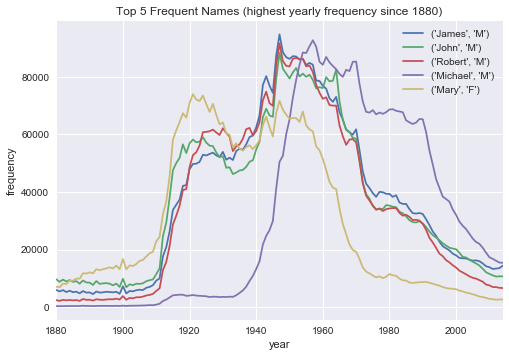

In [12]:
# print the most popular name (name with highest avg yearly frequency across history data)

N = 5
since=1880

frequent_name_billboard = get_frequent_name_billboard(since=since)
year_frequency = name_year_count.groupby(['name','gender','year']).frequency.sum()
for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_frequency[frequent_name_billboard.index[i]].dropna().plot(kind='line');
plt.legend(frequent_name_billboard.index[:N])
plt.title(f"Top {N} Frequent Names (highest yearly frequency since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Task 3: find out frequency trend by given (name, gender)

Find out what is the yearly frequency trend by given (name, gender)

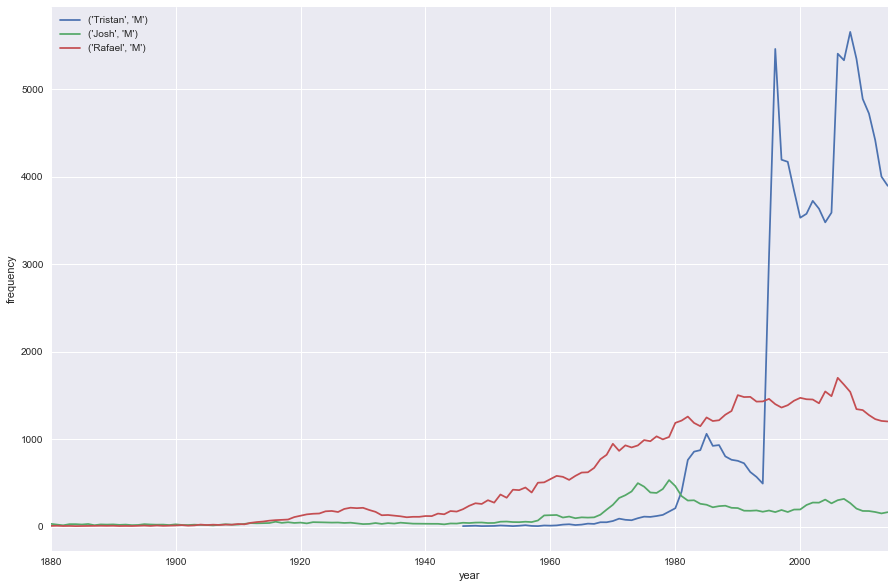

In [13]:
def print_name_frequency_trend(names,since=1880,figsize=(15,10)):
    """ Given a list of names, plot name yearly frequency trend"""
    plt.figure()
    plt.xlabel("year")
    plt.ylabel("frequency")
    year_frequency = name_year_count[name_year_count.year>=since].groupby(['name','gender','year']).frequency.sum()
    for name in names:
        year_frequency[name].plot(kind='line',figsize=figsize);
    plt.legend(names)

print_name_frequency_trend([('Tristan','M'),('Josh','M'),('Rafael','M')],since=1880)

### Task 4: find popular of names

Add column popularity by following definition:

$ popularity = \frac{frequency of (gender, name ,year)}{frequency of (gender,year)} $

Popularity is the percentage of frequency that a particular name takes among the same (year,gender) pair.

In [14]:
sample = raw_nat_sample.copy()

# prepare frequency_sum per (gender,year) group
pop_total = sample.groupby(['year','gender'])['frequency'].transform(sum)

# populate derived column: popularity
sample['popularity'] = sample['frequency']/pop_total

In [15]:
print(sample.shape)
print(raw_nat_sample.shape)
sample.head()

(1825737, 5)
(1825737, 4)


,name,year,gender,frequency,popularity
id,,,,,
1585933,Aaban,2007,M,5,0.000002
1654167,Aaban,2009,M,6,0.000003
1685637,Aaban,2010,M,9,0.000005
1718295,Aaban,2011,M,11,0.000006
1752147,Aaban,2012,M,11,0.000006


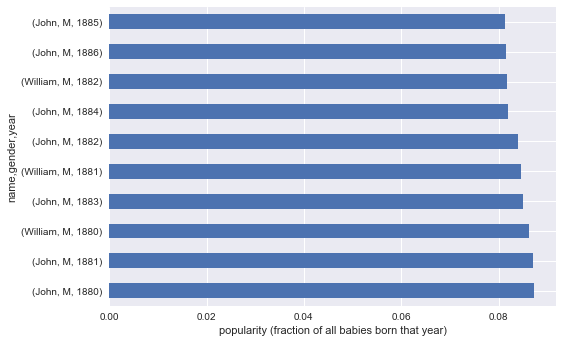

In [16]:
# show top N popular name of the year
plt.ylabel("(name,gender,year) pair")
plt.xlabel("popularity (fraction of all babies born that year)")
N = 10
sample.groupby(['name','gender','year']).popularity.sum().sort_values(ascending=False).head(N).plot(kind='barh');

### Task 5: which name has the largest sudden popularity gain v.s. 1 years before

In [17]:
# inspired by https://www.kaggle.com/dvasyukova/d/kaggle/us-baby-names/the-biggest-impacts-on-name-popularity

def popularity_diff(group,since=1880):
    '''
    group: group by object
    since: before this year, the 1st time you see a name is counted 0 pop diff
    '''
    # build year diff series
    yd = group.year.diff().fillna(0)
    # build popularity diff series
    popd = group.popularity.diff()
    # when there's a gap in year, treat the gap as 0, which means pop diff is the same as pop itself
    popd.loc[yd>1] = group.popularity.loc[yd>1]
    # reset first row per group to 0 before certain year
    popd.iloc[0] = group.popularity.iloc[0] if group.year.iloc[0] >= since else 0
    
    return popd

sample['popdiff']=sample.groupby(['name','gender']).apply(popularity_diff,since=2000).reset_index().set_index('id').popularity

In [18]:
def get_sudden_popular_name_billboard(since=1910):
    return sample[sample.year >=since].sort_values(by=['popdiff'],ascending=False)

In [19]:
def find_sudden_popular_rank(name,gender,since=1910):
    score = get_sudden_popular_name_billboard(since=since).reset_index()
    return score[(score.name==name) & (score.gender == gender)].index[0]+1

In [20]:
find_sudden_popular_rank('Sophia','F',since=since)

190

In [21]:
get_sudden_popular_name_billboard()[:10]

,name,year,gender,frequency,popularity,popdiff
id,,,,,,
431054,Linda,1947,F,99680,0.056232,0.022686
321476,Shirley,1935,F,42354,0.040396,0.018521
922362,Ashley,1983,F,33290,0.019932,0.011159
711390,Jennifer,1971,F,56785,0.034134,0.007731
726681,Jennifer,1972,F,63610,0.041815,0.007680
312297,Shirley,1934,F,22839,0.021875,0.007670
751898,Jason,1973,M,46689,0.029940,0.006864
645387,Michelle,1966,F,27153,0.016049,0.006861
844740,Amanda,1979,F,31927,0.019891,0.006493


In [22]:
# top N sudden popular names by gender
N = 5
since = 2000
gender = 'F'

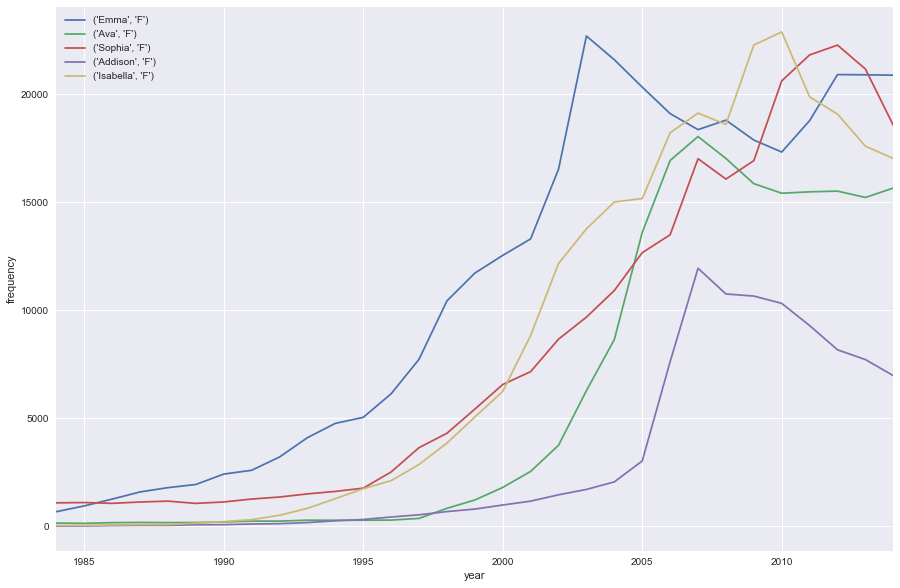

In [23]:
scores = get_sudden_popular_name_billboard(since=since)[['name','gender']]
names = [(name, gender) for name in scores.name[scores.gender == gender].unique()[:N]]
print_name_frequency_trend(names,since=1984)

### Task 6: find good name that starts with 'S', for both boy and girl

#### Frequent Name

In [24]:
N = 5
since = 1880
gender = 'F'

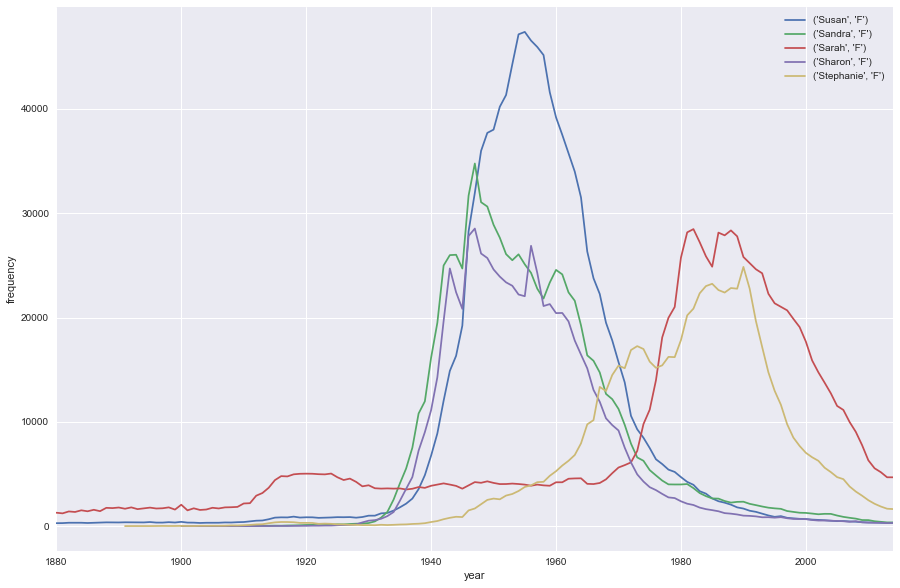

In [25]:
freq_names = get_frequent_name_billboard(since=since).reset_index()
print_name_frequency_trend(freq_names[(freq_names.gender == gender) & (freq_names.name.str.contains('^S'))][:N][['name','gender']].apply(tuple,axis=1),since=since)

#### Popular Name

In [26]:
N = 5
since = 2000
gender = 'F'

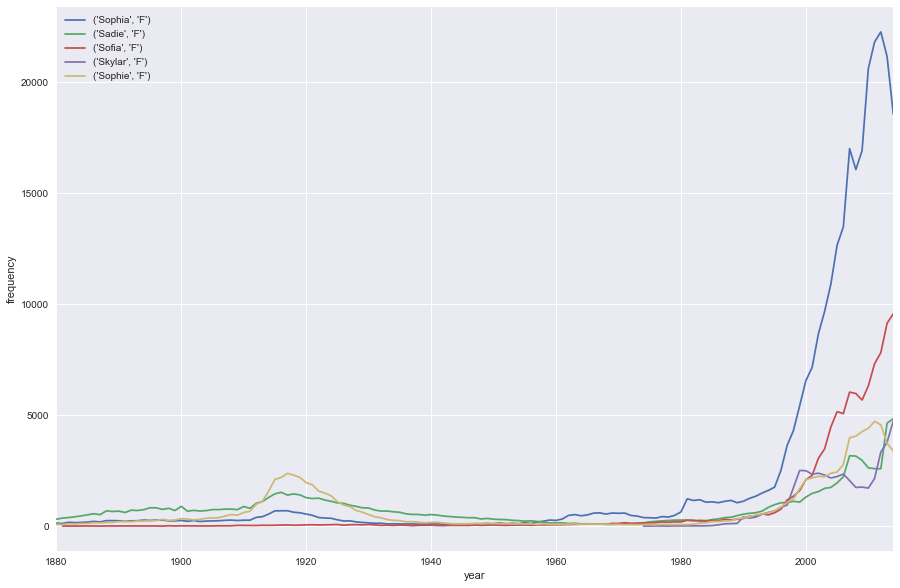

In [27]:
table = get_sudden_popular_name_billboard(since=since)

names = table[(table.name.str.contains('^S')) & (table.gender==gender)].groupby(['gender','name']).first().sort_values(by='popdiff',ascending=False).reset_index()[['name','gender']].apply(tuple,axis=1)[:N]

print_name_frequency_trend(names,since=1880)

### Task 7:  Analyze impact of movies on name

In [97]:
since = 1880

In [98]:
data = get_sudden_popular_name_billboard(since=since)

In [99]:
data = data[data.name == 'Tristan']

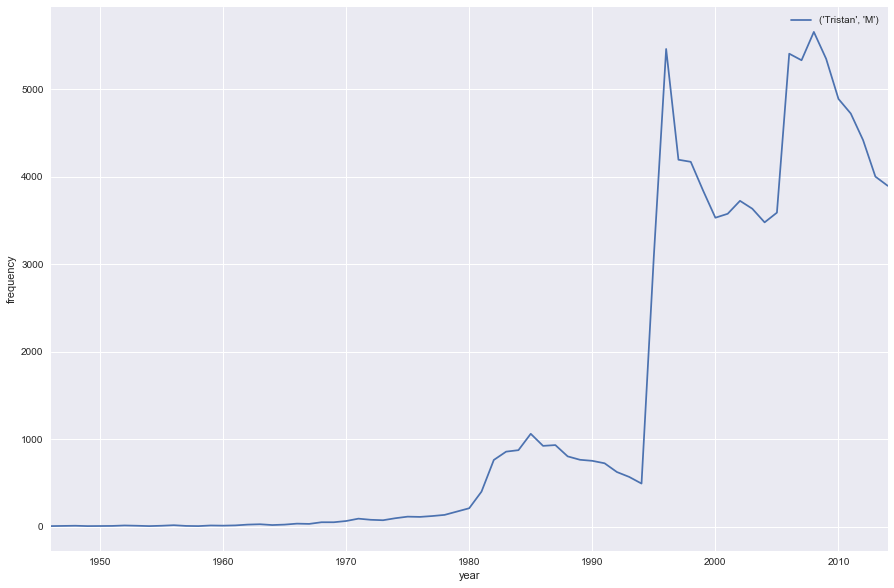

In [100]:
print_name_frequency_trend([('Tristan','M')])

[Lengend of the Fall (1994)](https://en.wikipedia.org/wiki/Legends_of_the_Fall)

### Task 8: Name Frequency Fit Distribution - Power Law

Power Law: $y = ax^b$

Log Power Law: $log(y) = log(a) + blog(x)$

Link Function: $log$

In [39]:
# from scipy import optimize
import statsmodels.formula.api as smf

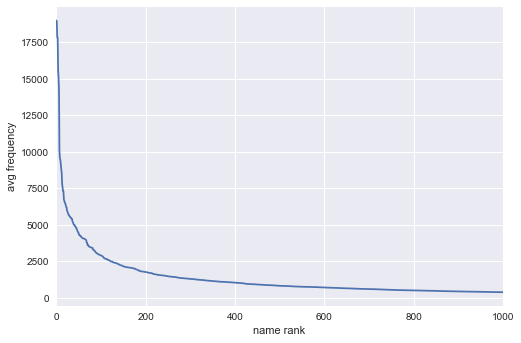

In [114]:
topN = 1000
freq = sample.groupby(['name'])['frequency'].mean().sort_values(ascending=False)[:topN]
freq = pd.DataFrame(freq).reset_index()
freq.frequency.plot();
plt.xlabel("name rank")
plt.ylabel("avg frequency");

In [115]:
ydata = freq.frequency.values / freq.frequency.sum()
xdata = freq.index.values + 1 # avoid 0, which gives inf

In [116]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

In [117]:
##########
# Fitting the data -- OLS
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

logx = np.log(xdata)
logy = np.log(ydata)
x = np.vander(logx,N=2)
result = smf.OLS(logy,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 3.390e+04
Date:                Wed, 08 Mar 2017   Prob (F-statistic):               0.00
Time:                        20:34:36   Log-Likelihood:                 654.94
No. Observations:                1000   AIC:                            -1306.
Df Residuals:                     998   BIC:                            -1296.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7438      0.004   -184.117      0.000      -0.752      -0.736
const         -2.8709      0.024   -118.575      0.000      -2.918      -2.823
==============================================================================
Omnibus:                      713.192   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21240.442
Skew:                          -2.873   Prob(JB):                         0.00
Kurtosis:                      24.835   Cond. No.                         37.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
index = result.params[0]
amp = np.exp(result.params[1])
print("index={},amp={}".format(index,amp))

index=-0.7437546925517757,amp=0.056648011564618815


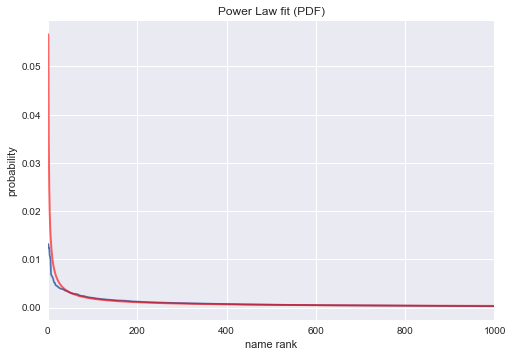

In [119]:
(freq.frequency / freq.frequency.sum()).plot();
x = np.linspace(1,topN,topN)
plt.plot(x, powerlaw(x,amp,index),'r-', lw=2, alpha=0.6, label='powerlaw pdf');
plt.xlabel("name rank")
plt.ylabel("probability")
plt.title("Power Law fit (PDF)");

### Task 8: Hypothesis Testing

Yesterday I attended a deeplearning4j workshop, and the guy sitting next to me from Salesforce is named Zachary.

$H_0$: I told the truth (because I always do)

$H_1$: I lied.

In [120]:
freq[freq.name=='Zachary']

,name,frequency
75,Zachary,3489.543624


In [121]:
powerlaw(76,amp,index)

0.0022611050240215159

The p-value of meeting a guy named Zachary is less than significant level α = 0.05

Therefore, we reject the null hypothesis, which means I lied.

### Task 9: study length of names - Fit Regression Model

In [43]:
sample['length']=sample.name.str.len()

In [44]:
sample.head()

,name,year,gender,frequency,popularity,popdiff,length
id,,,,,,,
1585933,Aaban,2007,M,5,0.000002,2.412539e-06,5
1654167,Aaban,2009,M,6,0.000003,3.030464e-06,5
1685637,Aaban,2010,M,9,0.000005,1.670186e-06,5
1718295,Aaban,2011,M,11,0.000006,1.106361e-06,5
1752147,Aaban,2012,M,11,0.000006,1.035864e-08,5


In [45]:
namelen = sample.groupby(['year'])['length'].mean()
namelen = pd.DataFrame(namelen).reset_index()

In [46]:
namelen.head()

,year,length
0,1880,5.700000
1,1881,5.674419
2,1882,5.724024
3,1883,5.697217
4,1884,5.716152


In [47]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

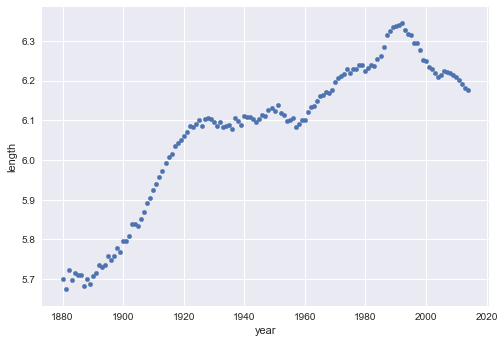

In [48]:
namelen.plot.scatter('year','length');

#### Linear

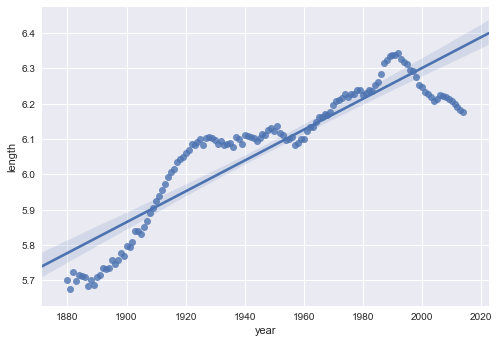

In [49]:
sns.regplot(namelen.year,namelen.length,order=1);

#### Polynomial

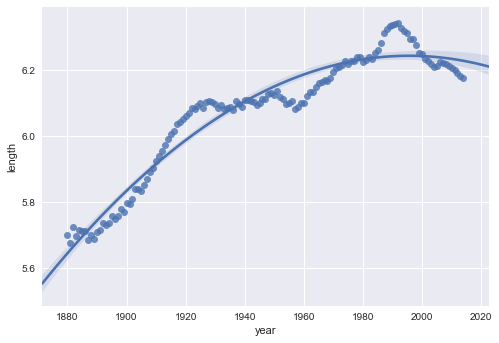

In [50]:
sns.regplot(namelen.year,namelen.length,order=2);

In [51]:
x = np.vander(namelen.year,N = 3)
y = namelen.length.values
result = smf.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1008.
Date:                Wed, 08 Mar 2017   Prob (F-statistic):           1.12e-80
Time:                        17:16:32   Log-Likelihood:                 223.44
No. Observations:                 135   AIC:                            -440.9
Df Residuals:                     132   BIC:                            -432.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.492e-05   2.96e-06    -15.163      0.000   -5.08e-05   -3.91e-05
x2             0.1793      0.012     15.541      0.000       0.156       0.202
const       -172.6564     11.228    -15.377      0.000    -194.867    -150.446
==============================================================================
Omnibus:                        8.007   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                5.665
Skew:                           0.370   Prob(JB):                       0.0589
Kurtosis:                       2.323   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
# predict
year_to_predict = 2020
result.predict([year_to_predict**2, year_to_predict, 1])

array([ 6.21739011])